Data Preprocess
==========================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from collections import OrderedDict
from sklearn import preprocessing
%matplotlib inline

1. Load Data
----------------------

In [2]:
train16=pd.read_csv('./Data/train_2016_v2.csv')

In [3]:
properties16=pd.read_csv('./Data/properties_2016.csv',low_memory=False)

In [4]:
train17=pd.read_csv('./Data/train_2017.csv')

In [5]:
properties17=pd.read_csv('./Data/properties_2017.csv',low_memory=False)

In [6]:
train=pd.concat([train16,train17],ignore_index=True)

In [7]:
properties=properties16

In [8]:
properties.update(properties17)

2. Get TrainSet
--------------------------

### Global Options

In [9]:
upper_logerror=0.4
lower_logerror=-0.4
cat_map_top_percent=0.95
scaling_range=(0,1)
normalization='l2'
random_seed=1234

### Global Archieve

In [10]:
preprocess_pipeline=OrderedDict()
features2impute_mode=[]
features2impute_mean=[]
features2impute_lr=[]
features2impute_knn=[]
featuresmustdrop=[]
featurescanbedrop=[]
category_features=[]
numerical_features=[]
segment_features=[]
special=[]

### Merge DataSets

In [11]:
train_properties=pd.merge(train,properties,on='parcelid')

#### Before Clean

In [12]:
shape=train_properties.shape
print('Raw TrainSet')
print('Total:'+str(shape[0])+'   Features:'+str(shape[1]-2))

Raw TrainSet
Total:167888   Features:58


#### After Clean

In [13]:
train_properties_clean=train_properties[(train_properties.logerror>=lower_logerror) & (train_properties.logerror<=upper_logerror)]
shape=train_properties_clean.shape
print('Cleaned TrainSet')
print('Total:'+str(shape[0])+'   Features:'+str(shape[1]-2))

Cleaned TrainSet
Total:164299   Features:58


3. Preprocess Function
-----------------------------------

In [14]:
def watch(prpty,fname,plot=True):
    feature=prpty[fname].copy()
    train_feature=pd.merge(train,prpty,on='parcelid')[fname].copy()
    print(fname)
    fvc=feature.value_counts(dropna=False)
    fvcdpna=feature.value_counts(dropna=True)
    tfvc=train_feature.value_counts(dropna=False)
    tfvcdpna=train_feature.value_counts(dropna=True)
    strs1='Full NaN : %.2f%%:'%(float(feature.isnull().sum()*100)/float(len(properties)))
    strs1+='   '+'Full NumOfCat : %d'%(len(fvc))
    strs1+='   '+'Full CatRatio : %.2f%%'%(float(len(fvcdpna)*100)/float(len(feature[feature.notnull()])))
    strs2='Train NaN : %.2f%%'%(float(train_feature.isnull().sum()*100)/float(len(train_properties)))
    strs2+='   '+'Train clean NaN : %.2f%%'%(float(train_feature.isnull().sum()*100)/float(len(train_properties_clean)))
    strs2+='   '+'Train NumOfCat : %d'%(len(tfvc))
    strs2+='   '+'Train CatRatio : %.2f%%'%(float(len(tfvcdpna)*100)/float(len(train_feature[feature.notnull()])))
    print(strs1)
    print(strs2)
    print(str(fvcdpna.tolist()[:10]))
    if len(fvcdpna.value_counts())>1:
        if plot:
            plt.figure(figsize=(15,3))
            plt.subplot(121)
            sns.distplot(fvcdpna,kde=False)
            plt.subplot(122)
            sns.distplot(feature[feature.notnull()],hist=False)

In [15]:
def cat_process(prpty,fname,top_percent=cat_map_top_percent,rank_by_properties=True,custom=None):
    # automatically asign 'N' to NaN, other letters to cataglories and group remaining cataglories into class 'R'
    # N for NaN  R for Rare 
    feature=prpty[fname].copy()
    train_feature=pd.merge(train,prpty,on='parcelid')[fname].copy()
    charlist=['A','B','C','D','E','F','G','H','I','J','K','L','M','O','P','Q','S','T','U','V','W','X','Y','Z']
    plt.figure(figsize=(15,6))
    if custom is not None:
        feature=feature.apply(custom)
        train_feature=train_feature.apply(custom)
    feature_counts=feature.value_counts(dropna=True)
    train_feature_counts=train_feature.value_counts(dropna=True)
#     plt.subplot(221)
#     plt.title('Property Raw')
#     (feature_counts/feature.notnull().sum()).plot(kind='bar',x='Cataglories',y='%')
#     for i,v in enumerate(feature_counts):
#         plt.text(i,float(v)/(feature.notnull().sum()),v,ha='center',va='bottom',color='orange')
#     plt.subplot(223)
#     plt.title('Train Raw')
#     (train_feature_counts/train_feature.notnull().sum()).plot(kind='bar',logy=True,x='Cataglories',y='Log%')
#     for i,v in enumerate(train_feature_counts):
#         plt.text(i,float(v)/(train_feature.notnull().sum()),v,ha='center',va='bottom',color='orange')
    map_func={'N':'N'}
    rank=feature_counts.tolist()
    if not rank_by_properties:rank=train_feature_counts
    for i,n in enumerate(rank):
        if top_percent==0:break
        map_func[feature_counts.index[i]]=charlist[i]
        if float(sum(rank[:i+1]))/(sum(rank))>top_percent:break
    print(map_func)
    feature=feature.fillna('N')
    train_feature=train_feature.fillna('N')
    feature=feature.map(map_func)
    train_feature=train_feature.map(map_func)
    feature=feature.fillna('R')
    train_feature=train_feature.fillna('R')
    def foo(column):
        col=column.copy()
        if custom is not None:
            col.apply(custom)
        col=col.fillna('N')
        col=col.map(map_func)
        col=col.fillna('R')
        return col
    preprocess_pipeline[fname]=foo
    plt.subplot(121)
    plt.title('Property Adjust')
    feature_counts=feature.value_counts(dropna=False)
    (feature_counts/len(feature)).plot(kind='bar',x='Cataglories',y='%')
    for i,v in enumerate(feature_counts):
        plt.text(i,float(v)/len(feature),v,ha='center',va='bottom',color='orange')
    plt.subplot(122)
    plt.title('Train Adjust')
    train_feature_counts=train_feature.value_counts(dropna=False)
    (train_feature_counts/len(train_feature)).plot(kind='bar',logy=True,x='Cataglories',y='Log%')
    for i,v in enumerate(train_feature_counts):
        plt.text(i,float(v)/len(train_feature),v,ha='center',va='bottom',color='orange')

In [16]:
def num_process(prpty,fname,scaling=False,log=False,norm=False,custom=None):
    feature=prpty[fname].copy()
    train_feature=pd.merge(train,prpty,on='parcelid')[fname].copy()
    feature=feature[feature.notnull()]
    train_feature=train_feature[train_feature.notnull()]
    plt.figure(figsize=(15,6))
    if custom is None:
        def fn(x):
            if scaling:
                x=(x-min(x))/(max(x)-min(x))
            if log:
                x=np.log(x+1)
            if norm:
                x = preprocessing.normalize(x.values.reshape(1,-1), norm='l2')
                x=x[0]
            return x
    else:
        fn=custom
    feature=fn(feature)
    train_feature=fn(train_feature)
    preprocess_pipeline[fname]=fn
    plt.subplot(121)
    plt.title('Property Adjust')
    sns.distplot(feature)
    plt.subplot(122)
    plt.title('Train Adjust')
    sns.distplot(train_feature)

In [17]:
def seg_process(prpty,fname,n_seg=3,top_percent=cat_map_top_percent,scaling=False,log=False,norm=False,rank_by_properties=True,custom=None):
    feature=prpty[fname].copy()
    train_feature=pd.merge(train,prpty,on='parcelid')[fname].copy()
    charlist=['A','B','C','D','E','F','G','H','I','J','K','L','M','O','P','Q','S','T','U','V','W','X','Y','Z']
    if custom is None:
        def fn(x):
            if scaling:
                x=(x-min(x))/(max(x)-min(x))
            if log:
                x=np.log(x+1)
            if norm:
                x = preprocessing.normalize(x.values.reshape(1,-1), norm='l2')
                x=x[0]
            return x
    else:
        fn=custom
    feature=fn(feature[feature.notnull()])
    train_feature=fn(train_feature[train_feature.notnull()])
    
    
    ft=feature.copy()
    if not rank_by_properties:ft=train_feature.copy()
    mean=ft.mean()
    rad=(max(ft)-min(ft))/2
    drad=rad
    ratio=1.
    eps=1e-4
    i=0
    while ratio<top_percent-eps or ratio>top_percent+eps:
        if ratio<top_percent-eps:
            drad+=drad/2
        else:
            drad/=2
        ratio=float(len(ft[(ft>=mean-drad) & (ft<=mean+drad)]))/float(len(ft))
        i+=1
        if i>10000:
            print 'Time Out'
            break
    print('Values Which In Range Has A Ratio : %.2f%%'%(ratio*100))
    print('Values large than {} and less than {} will be map to RL RG'.format(mean-drad,mean+drad))
    
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.title('Property Adjust Before Segment')
    plt.plot([mean-drad,mean-drad],[0,1],c='r')
    plt.plot([mean+drad,mean+drad],[0,1],c='r')
    for i in range(1,n_seg):
        plt.plot([mean-drad+i*((drad*2)/n_seg),mean-drad+i*((drad*2)/n_seg)],[0,1],c='y')
    sns.distplot(feature)
    plt.subplot(122)
    plt.title('Train Adjust Before Segment')
    plt.plot([mean-drad,mean-drad],[0,1],c='r')
    plt.plot([mean+drad,mean+drad],[0,1],c='r')
    for i in range(1,n_seg):
        plt.plot([mean-drad+i*((drad*2)/n_seg),mean-drad+i*((drad*2)/n_seg)],[0,1],c='y')
    sns.distplot(train_feature)
    
    def f(x):
        x=fn(x)
        x=x.fillna('N')
        def s(n):
            if n=='N':
                return n
            if n>=mean-drad and n<=mean+drad:
                return charlist[int((n-mean+drad)/((drad*2)/n_seg))]
            else:
                if n<mean-drad:
                    return 'RL'
                else:
                    return 'RG'
        x=x.apply(s)
        return x
    
    feature=f(properties[fname].copy())
    train_feature=f(train_properties_clean[fname].copy())

    preprocess_pipeline[fname]=f
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.title('Property Adjust After Segment')
    feature_counts=feature.value_counts(dropna=False)
    (feature_counts/len(feature)).plot(kind='bar',x='Cataglories',y='%')
    for i,v in enumerate(feature_counts):
        plt.text(i,float(v)/len(feature),v,ha='center',va='bottom',color='orange')
    plt.subplot(122)
    plt.title('Train Adjust After Segment')
    train_feature_counts=train_feature.value_counts(dropna=False)
    (train_feature_counts/len(train_feature)).plot(kind='bar',logy=True,x='Cataglories',y='Log%')
    for i,v in enumerate(train_feature_counts):
        plt.text(i,float(v)/len(train_feature),v,ha='center',va='bottom',color='orange')

4. Feature Classification
---------------------------

In [13]:
features2impute_mode=[]
features2impute_mean=[]
features2impute_lr=[]
features2impute_knn=[]
featuresmustdrop=[]
featurescanbedrop=[]
category_features=[]
numerical_features=[]
segment_features=[]
special=[]

In [16]:
# class fc:
#     stop=False
# def inpbox(str):
#     asw=raw_input(str+'     ')
#     if asw == "q":
#         fc.stop=True
#     else:
#         return asw
# for name in train_properties_clean.columns.tolist():
#     if fc.stop:
#         break
#     if name not in [target,pid,'transactiondate']:
#         watch(name,False)
#         asw=inpbox('Drop this ? (y/n)')
#         if asw=='y':
#             asw=inpbox('Must ? (y/n)')
#             if asw=='y':
#                 featuresmustdrop.append(name)
#             else:
#                 featurescanbedrop.append(name)
#         asw=inpbox('Need to be impute ? (y/n)')
#         if asw=='y':
#             asw=inpbox('knn ? (y/n)')
#             if asw=='y':
#                 features2impute_knn.append(name)
#             else:
#                 asw=inpbox('mode ? (y/n)')
#                 if asw=='y':
#                     features2impute_mode.append(name)
#                 else:
#                     asw=inpbox('mean ? (y/n)')
#                     if asw=='y':
#                         features2impute_mean.append(name)
#                     else:
#                         features2impute_lr.append(name)
#         asw=inpbox('Asign to Category ? (y/n)')
#         if asw=='y':
#             category_features.append(name)
#         else:
#             asw=inpbox('Asign to Numerical ? (y/n)')
#             if asw=='y':
#                 numerical_features.append(name)
#             else:
#                 asw=inpbox('Asign to Segment ? (y/n)')
#                 if asw=='y':
#                     segment_features.append(name)
#                 else:
#                     asw=inpbox('Asign to Special ? (y/n)')
#                     if asw=='y':
#                         special.append(name)
#         print '\r\n\r\n\r\n'

airconditioningtypeid
Full NaN : 72.82%:   Full NumOfCat : 8   Full CatRatio : 0.00%
Train NaN : 66.53%   Train clean NaN : 67.92%   Train NumOfCat : 7   Train CatRatio : 0.03%
[742364L, 58457L, 8795L, 1818L, 59L, 19L, 7L]
Drop this ? (y/n)     n
Need to be impute ? (y/n)     n
Asign to Category ? (y/n)     y




architecturalstyletypeid
Full NaN : 99.80%:   Full NumOfCat : 9   Full CatRatio : 0.13%
Train NaN : 97.67%   Train clean NaN : 99.71%   Train NumOfCat : 7   Train CatRatio : 3.30%
[5251L, 380L, 201L, 150L, 58L, 19L, 1L, 1L]
Drop this ? (y/n)     y
Must ? (y/n)     y
Need to be impute ? (y/n)     n
Asign to Category ? (y/n)     y




basementsqft
Full NaN : 99.95%:   Full NumOfCat : 752   Full CatRatio : 46.13%
Train NaN : 97.91%   Train clean NaN : 99.95%   Train NumOfCat : 38   Train CatRatio : 74.00%
[25L, 21L, 21L, 18L, 16L, 15L, 12L, 12L, 12L, 11L]
Drop this ? (y/n)     y
Must ? (y/n)     y
Need to be impute ? (y/n)     n
Asign to Category ? (y/n)     n
Asign to Numerical 

Drop this ? (y/n)     y
Must ? (y/n)     n
Need to be impute ? (y/n)     n
Asign to Category ? (y/n)     y




heatingorsystemtypeid
Full NaN : 39.49%:   Full NumOfCat : 15   Full CatRatio : 0.00%
Train NaN : 37.10%   Train clean NaN : 37.87%   Train NumOfCat : 13   Train CatRatio : 0.02%
[1156830L, 595453L, 27480L, 21107L, 3216L, 1342L, 586L, 262L, 41L, 39L]
Drop this ? (y/n)     n
Need to be impute ? (y/n)     y
knn ? (y/n)     y
Asign to Category ? (y/n)     y




latitude
Full NaN : 0.38%:   Full NumOfCat : 852326   Full CatRatio : 28.66%
Train NaN : 0.00%   Train clean NaN : 0.00%   Train NumOfCat : 71847   Train CatRatio : 81.25%
[862L, 760L, 740L, 611L, 568L, 559L, 555L, 553L, 541L, 524L]
Drop this ? (y/n)     n
Need to be impute ? (y/n)     y
knn ? (y/n)     n
mode ? (y/n)     n
mean ? (y/n)     y
Asign to Category ? (y/n)     n
Asign to Numerical ? (y/n)     n
Asign to Segment ? (y/n)     n
Asign to Special ? (y/n)     y




longitude
Full NaN : 0.38%:   Full NumOfCat : 104255

Asign to Category ? (y/n)     y




unitcnt
Full NaN : 33.76%:   Full NumOfCat : 147   Full CatRatio : 0.01%
Train NaN : 34.85%   Train clean NaN : 35.58%   Train NumOfCat : 11   Train CatRatio : 0.02%
[1780051L, 115652L, 39877L, 39830L, 588L, 363L, 178L, 167L, 97L, 91L]
Drop this ? (y/n)     n
Need to be impute ? (y/n)     y
knn ? (y/n)     y
Asign to Category ? (y/n)     n
Asign to Numerical ? (y/n)     y




yardbuildingsqft17
Full NaN : 97.31%:   Full NumOfCat : 1637   Full CatRatio : 2.04%
Train NaN : 95.07%   Train clean NaN : 97.05%   Train NumOfCat : 565   Train CatRatio : 20.91%
[3190L, 2980L, 2272L, 1492L, 1443L, 1313L, 1232L, 1136L, 1119L, 1026L]
Drop this ? (y/n)     y
Must ? (y/n)     n
Need to be impute ? (y/n)     n
Asign to Category ? (y/n)     n
Asign to Numerical ? (y/n)     n
Asign to Segment ? (y/n)     y




yardbuildingsqft26
Full NaN : 99.91%:   Full NumOfCat : 595   Full CatRatio : 22.44%
Train NaN : 97.86%   Train clean NaN : 99.90%   Train NumOfCat : 72   Trai

In [18]:
features2impute_mode=['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'fips', 'fullbathcnt', 'propertycountylandusecode', 'propertylandusetypeid','rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt', 'assessmentyear', 'censustractandblock']
features2impute_mean=['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'latitude', 'longitude', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'lotsizesquarefeet']
features2impute_knn=['buildingqualitytypeid', 'heatingorsystemtypeid', 'propertyzoningdesc', 'unitcnt']
featuresmustdrop=['architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'typeconstructiontypeid']
featurescanbedrop=['decktypeid', 'fireplacecnt', 'hashottuborspa', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'storytypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'taxdelinquencyyear']
category_features=['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid', 'fips', 'hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'regionidcounty', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag']
numerical_features=['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fullbathcnt', 'lotsizesquarefeet', 'roomcnt', 'unitcnt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']
segment_features=['basementsqft', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'poolsizesum', 'yardbuildingsqft17', 'yardbuildingsqft26']
special=['latitude', 'longitude', 'propertycountylandusecode', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidneighborhood', 'regionidzip', 'yearbuilt', 'assessmentyear', 'taxdelinquencyyear', 'censustractandblock']

5. Impute Missing Data By Simple Methods
---------------------------------------------

In [19]:
fullsets=properties.copy()

In [20]:
for f in features2impute_mean:
    fullsets[f]=fullsets[f].fillna(fullsets[f].mean())

In [21]:
for f in features2impute_mode:
    fullsets[f]=fullsets[f].fillna(fullsets[f].mode().tolist()[0])

6. Impute Missing Data By ML Models
---------------------------------------------

In [22]:
from sklearn import linear_model,svm,neighbors,ensemble
from sklearn import preprocessing, model_selection
from sklearn import metrics

In [23]:
complete_features=features2impute_mean+features2impute_mode
complete_features.remove('propertycountylandusecode')
imputefullsets=fullsets.copy()

In [24]:
imputedatasets=imputefullsets[complete_features].copy()
for f in ['buildingqualitytypeid','heatingorsystemtypeid','unitcnt']:
    print(f)
    train_x=imputedatasets[imputefullsets[f].notnull()]
    train_y=imputefullsets[f][imputefullsets[f].notnull()]
    impute_x=imputedatasets[imputefullsets[f].isnull()]
    model = ensemble.RandomForestClassifier()
    model.fit(train_x,train_y)
    print('ok')
    scores=model.score(train_x,train_y)
    print('R2 Score : '+str(scores.mean()))
    imputefullsets.at[imputefullsets[f].isnull(),f]=model.predict(impute_x)

buildingqualitytypeid
ok
R2 Score : 0.988157806698
heatingorsystemtypeid
ok
R2 Score : 0.989199035403
unitcnt
ok
R2 Score : 0.994827689477


{'LARS': 'F', 'LBR': 'E', 'LCR': 'B', 'SCUR': 'H', 'LARD': 'C', 'N': 'N', 'LARE': 'G', 'LCA': 'D', 'LAR': 'A'}


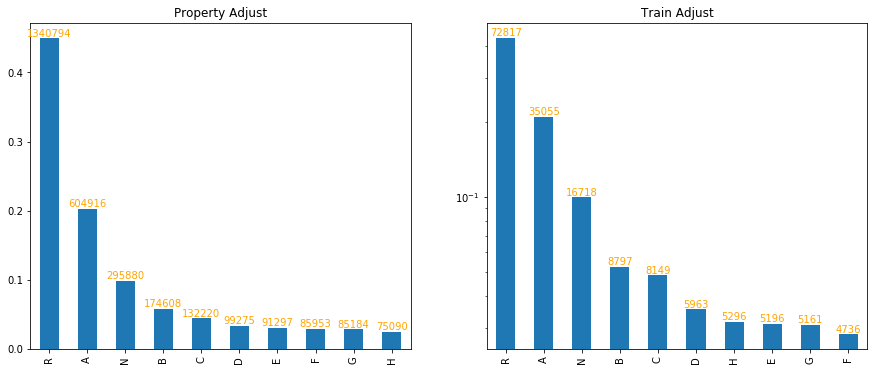

In [25]:
def c(x):
    l=''
    if x is np.nan:
        return x
    for i in str(x):
        if i.isalpha():
            l=l+i
        else:
            break
    return l
f='propertyzoningdesc'
cat_process(imputefullsets,f,top_percent=0.5,custom=c)
imputefullsets[f]=preprocess_pipeline[f](imputefullsets[f])

In [26]:
print(f)
train_x=imputedatasets[imputefullsets[f]!='N']
train_y=imputefullsets[f][imputefullsets[f]!='N']
impute_x=imputedatasets[imputefullsets[f]=='N']
model = ensemble.RandomForestClassifier()
model.fit(train_x,train_y)
print('ok')
scores=model.score(train_x,train_y)
print('R2 Score : '+str(scores.mean()))
imputefullsets.at[imputefullsets[f]=='N',f]=model.predict(impute_x)

propertyzoningdesc
ok
R2 Score : 0.998966659812


7. Categorical Data
-------------------------------------

In [27]:
print category_features

['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid', 'fips', 'hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'regionidcounty', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag']


{1.0: 'A', 13.0: 'B', 'N': 'N'}
{8.0: 'B', 2.0: 'C', 7.0: 'A', 'N': 'N'}
{3.0: 'B', 4.0: 'A', 'N': 'N'}
{4.0: 'A', 5.0: 'E', 6.0: 'C', 7.0: 'B', 8.0: 'D', 9.0: 'F', 'N': 'N'}
{66.0: 'A', 'N': 'N'}
{6059.0: 'B', 6037.0: 'A', 6111.0: 'C', 'N': 'N'}
{True: 'A', 'N': 'N'}
{2.0: 'A', 7.0: 'B', 'N': 'N'}
{1.0: 'A', 'N': 'N'}
{1.0: 'A', 'N': 'N'}
{1.0: 'A', 'N': 'N'}
{1.0: 'A', 'N': 'N'}
{261.0: 'A', 263.0: 'E', 266.0: 'B', 269.0: 'D', 'N': 'N', 246.0: 'C'}
{2061.0: 'C', 3101.0: 'A', 1286.0: 'B', 'N': 'N'}
{7.0: 'A', 'N': 'N'}
{1.0: 'A', 'N': 'N'}
{6.0: 'A', 'N': 'N'}
{1.0: 'A', 2.0: 'B', 'N': 'N'}
{True: 'A', 'N': 'N'}
{'Y': 'A', 'N': 'N'}


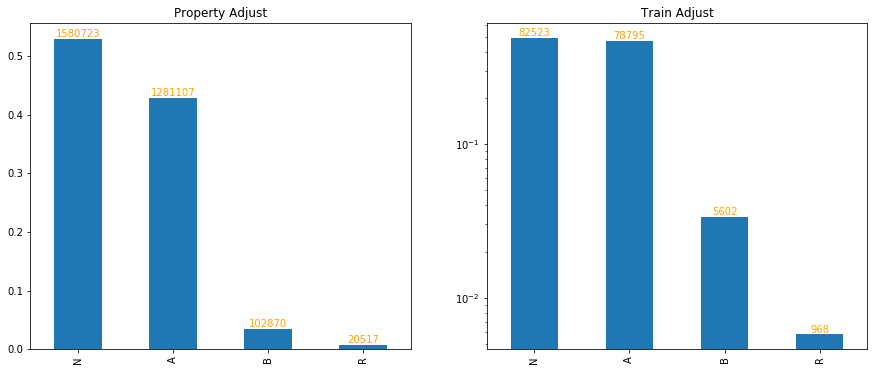

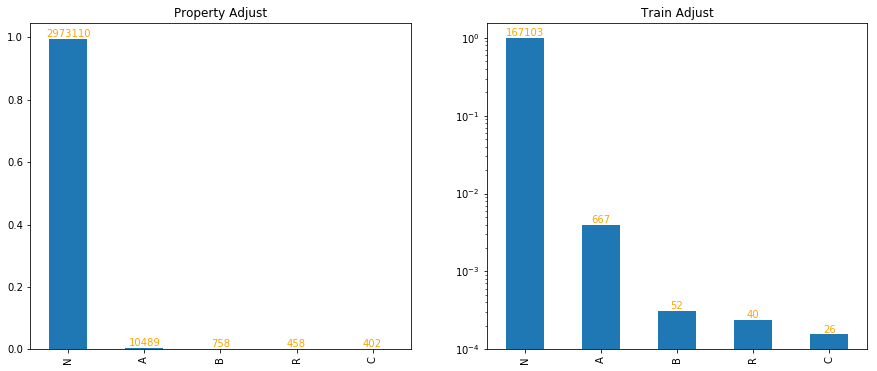

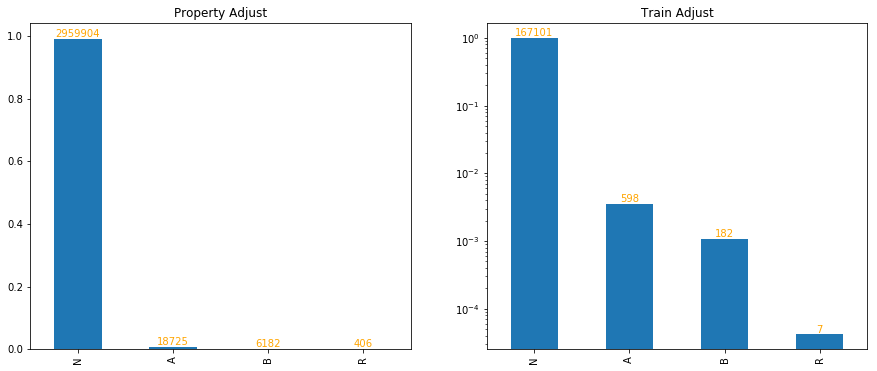

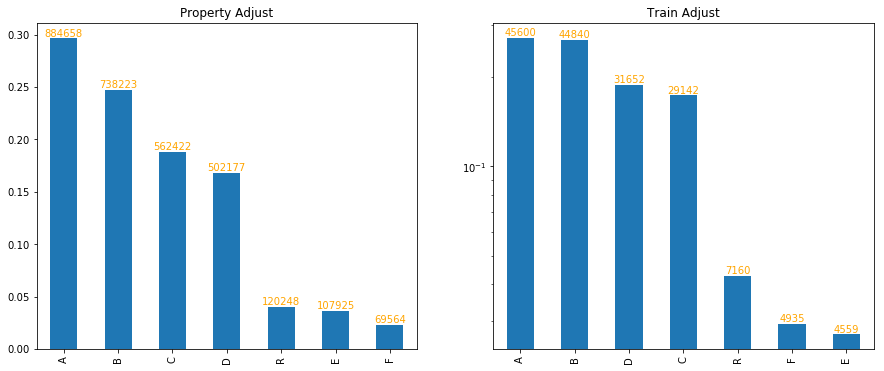

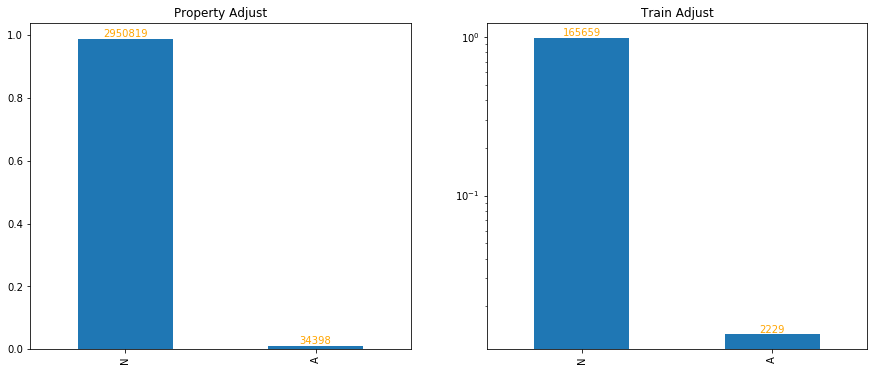

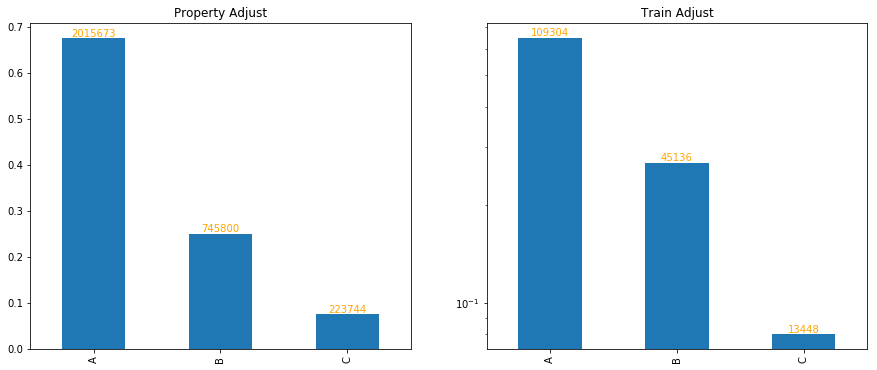

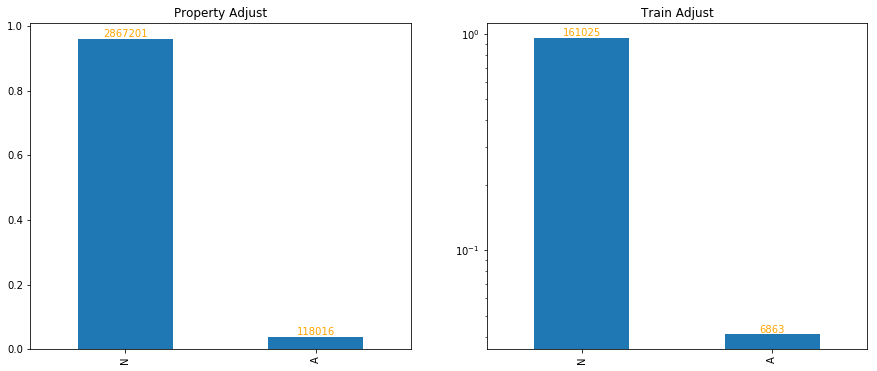

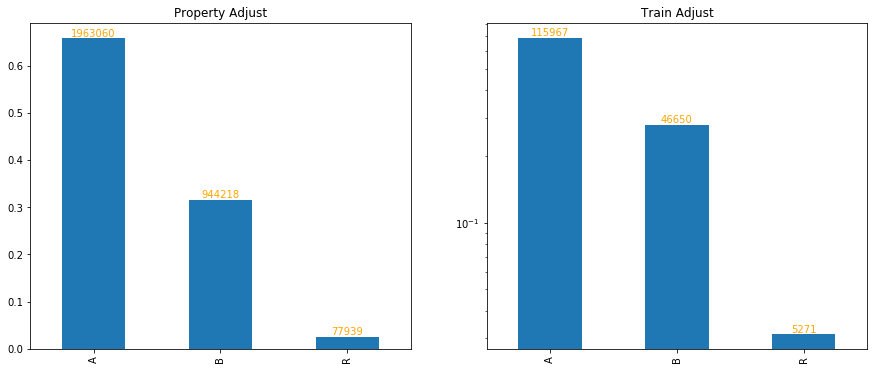

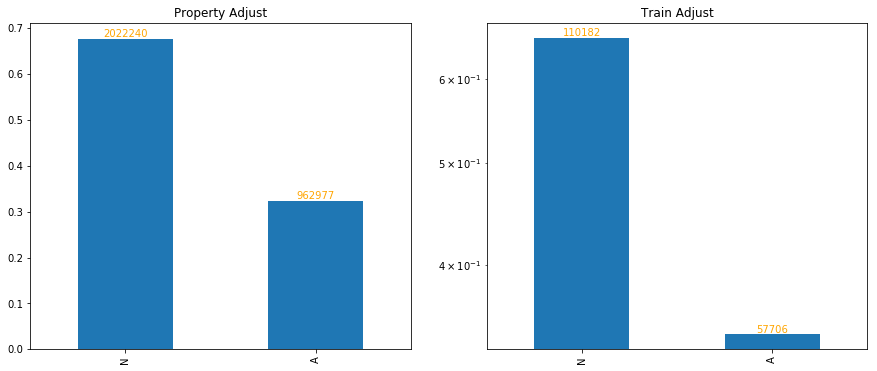

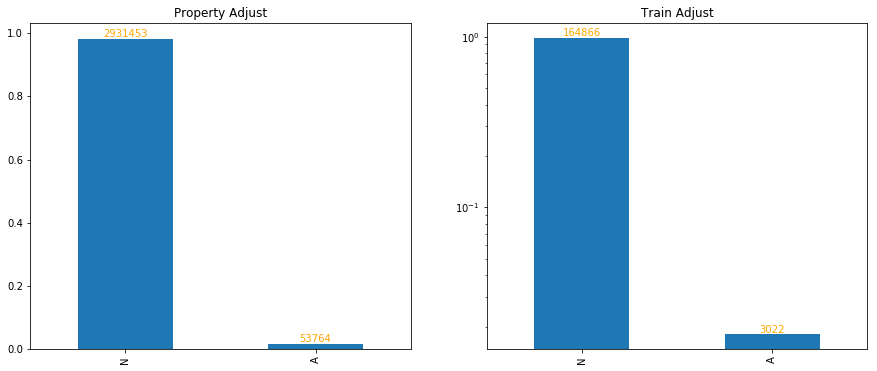

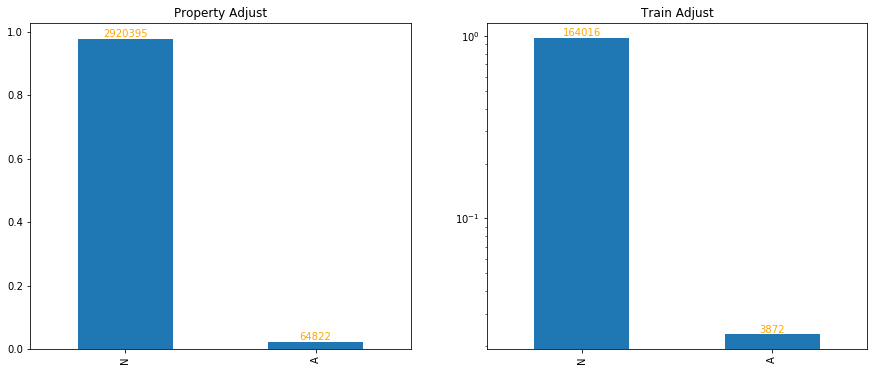

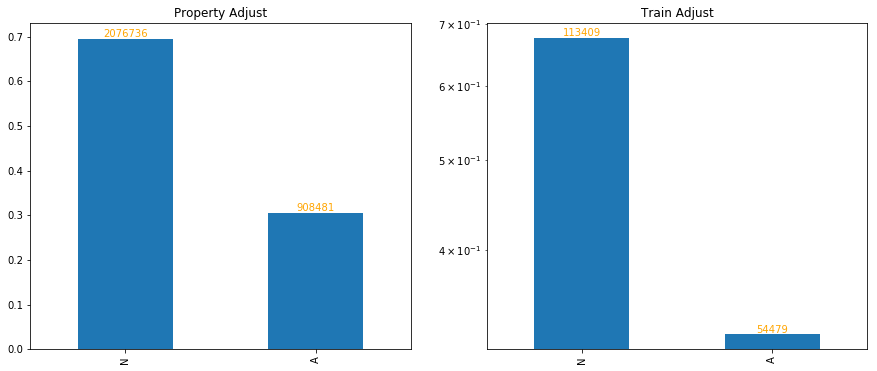

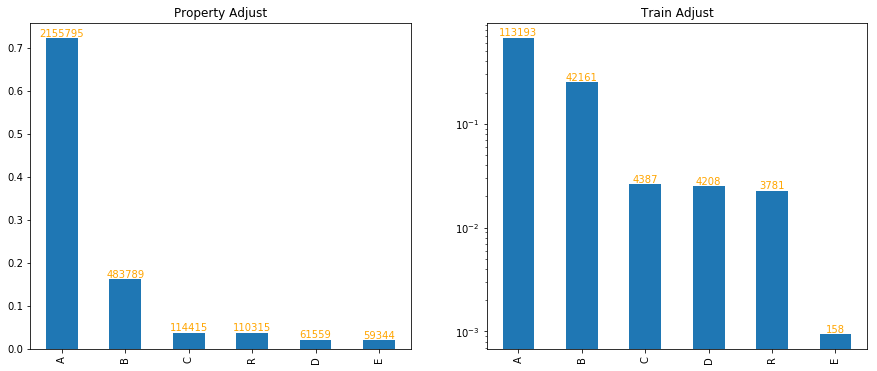

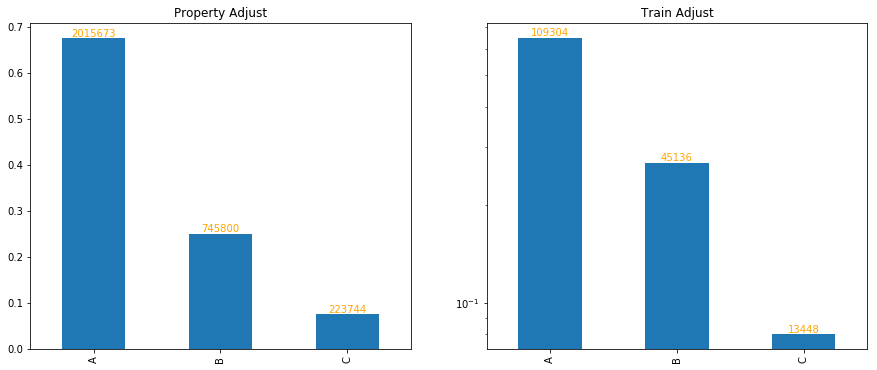

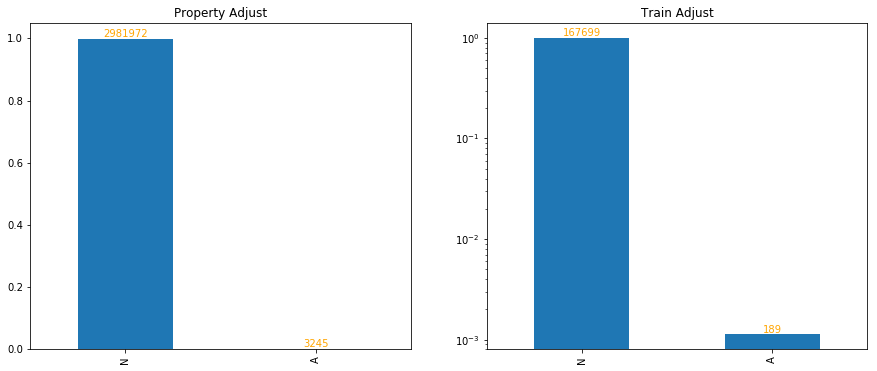

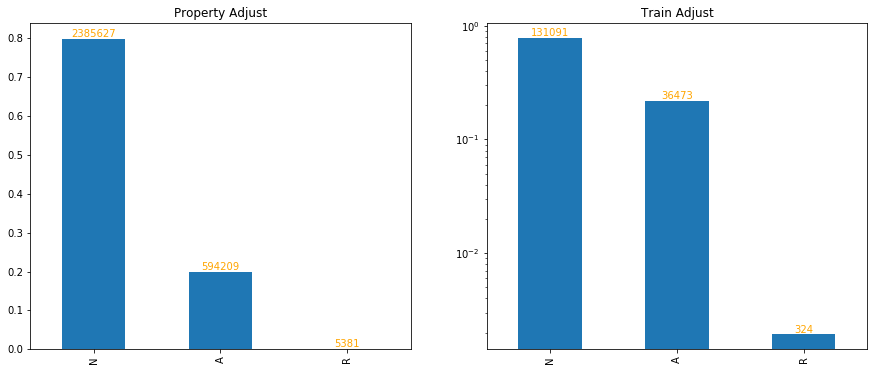

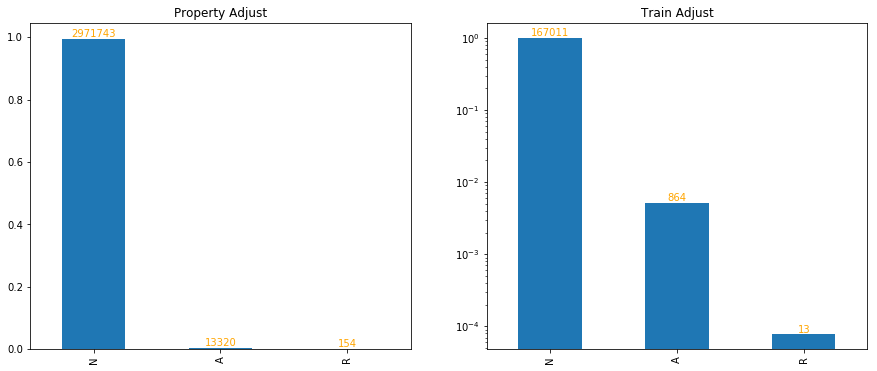

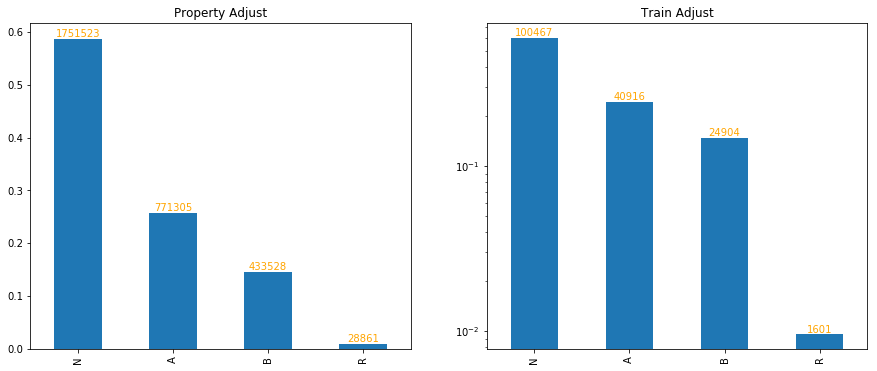

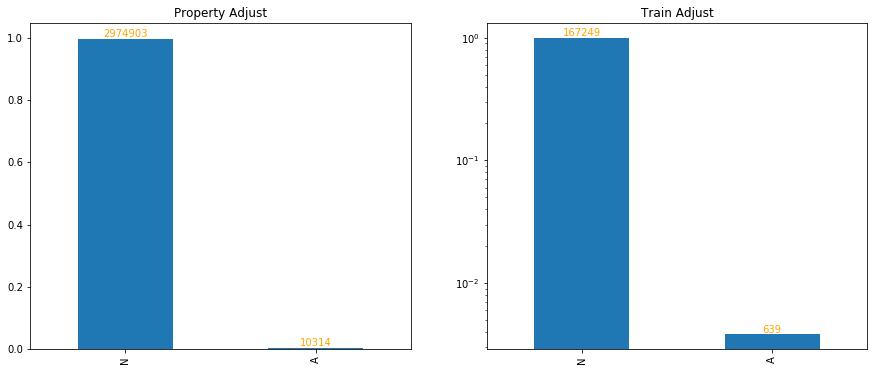

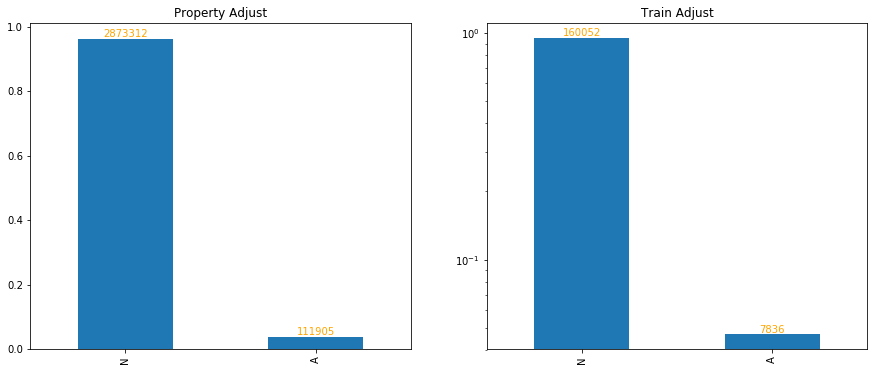

In [28]:
for f in category_features:
    cat_process(imputefullsets,f)

8. Numerical Data
-------------------------------------

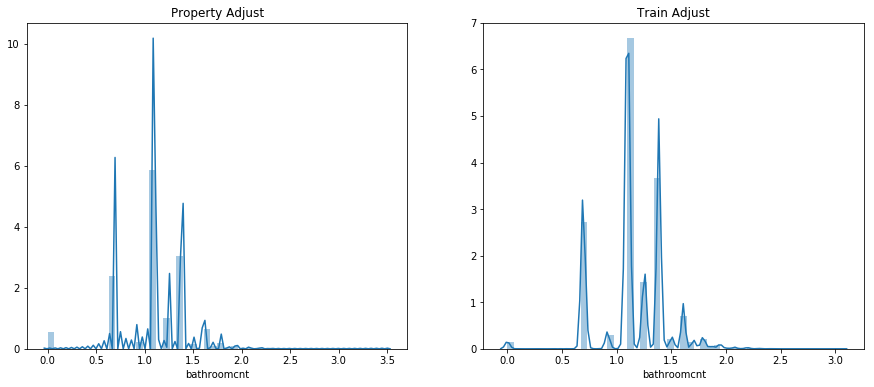

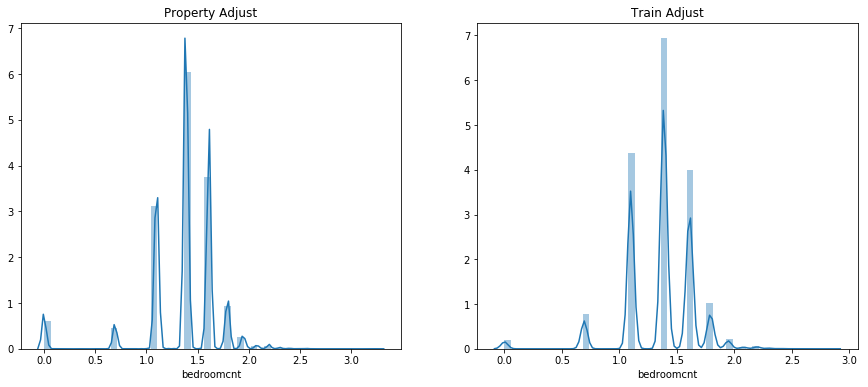

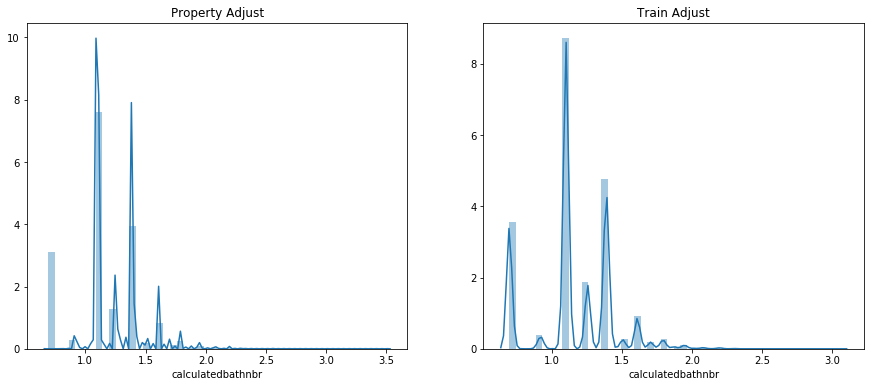

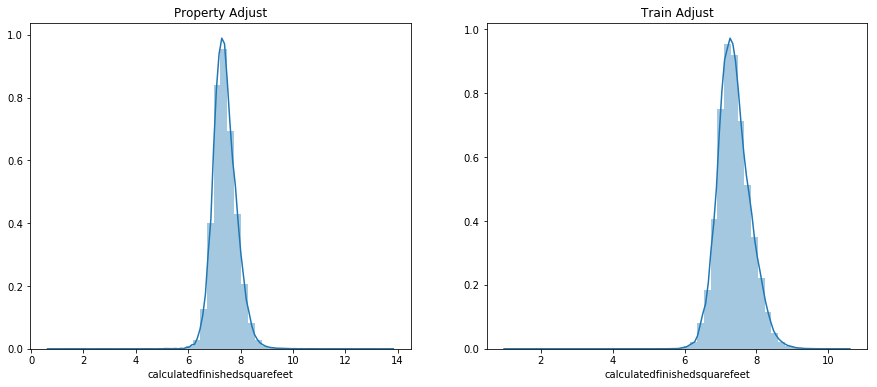

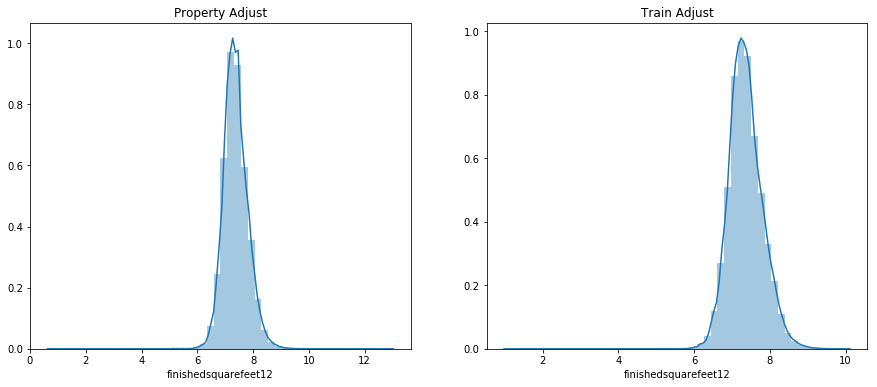

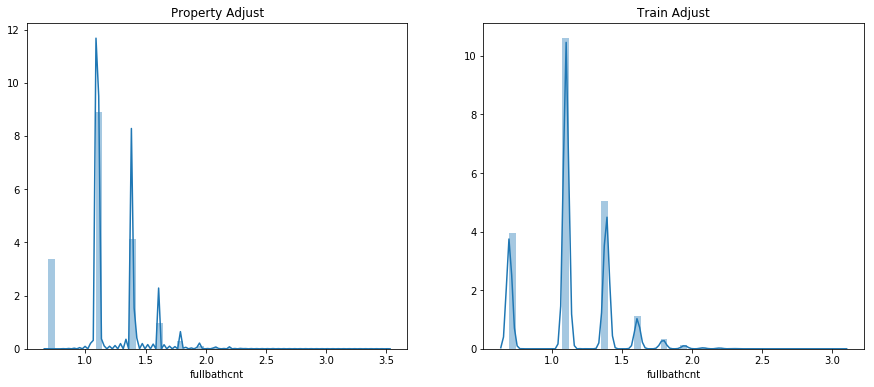

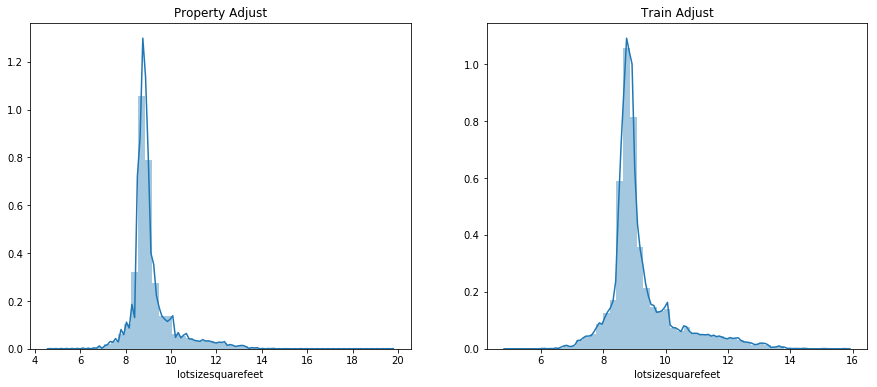

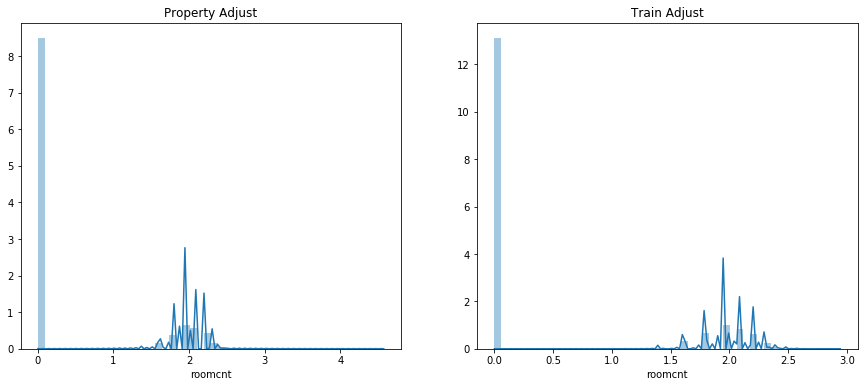

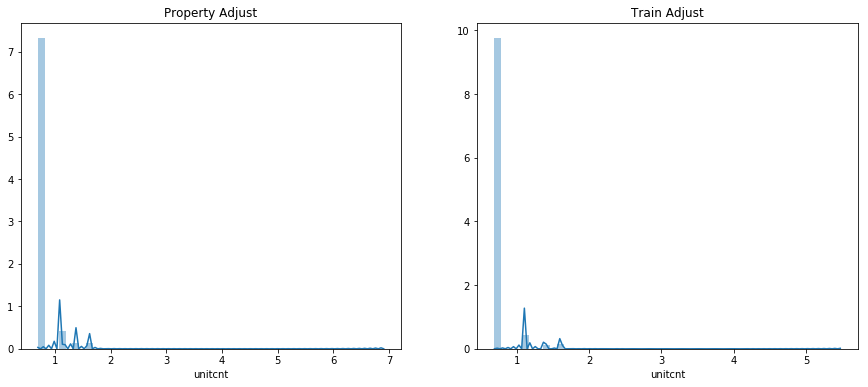

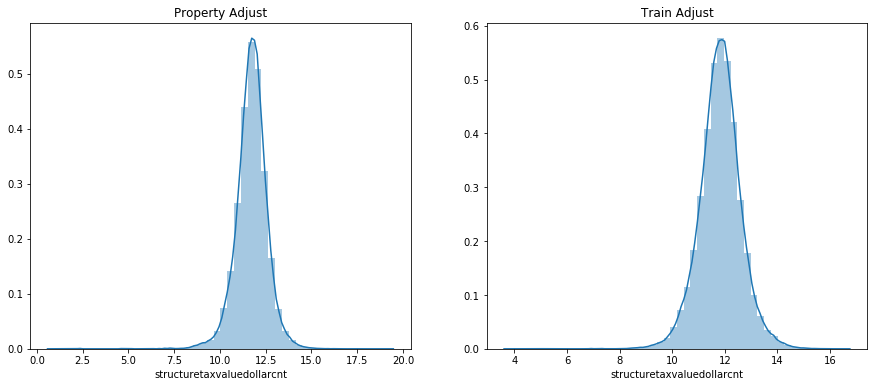

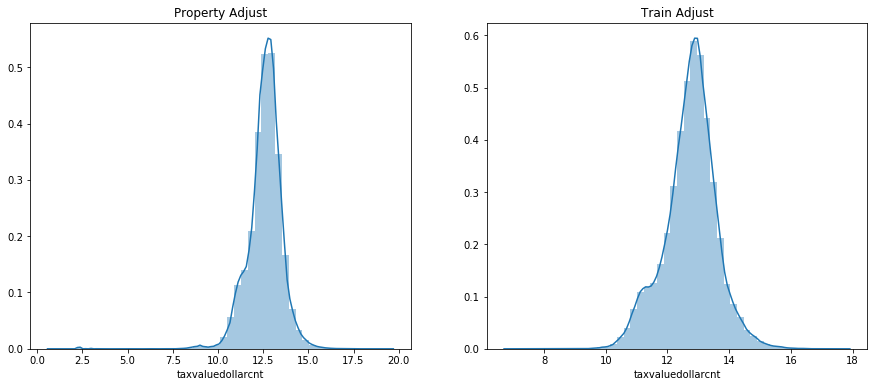

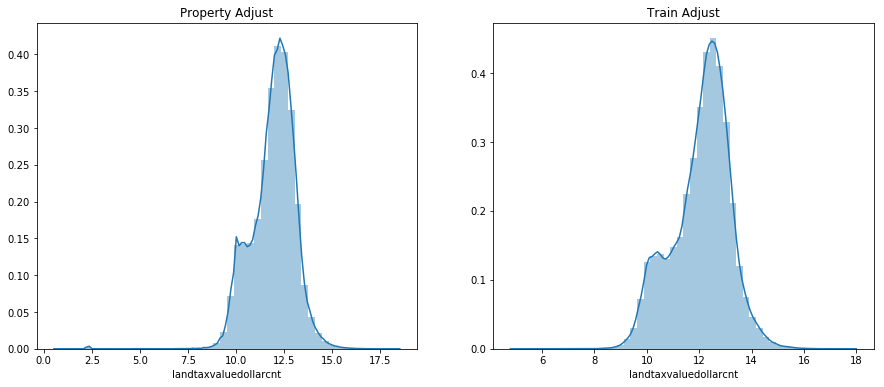

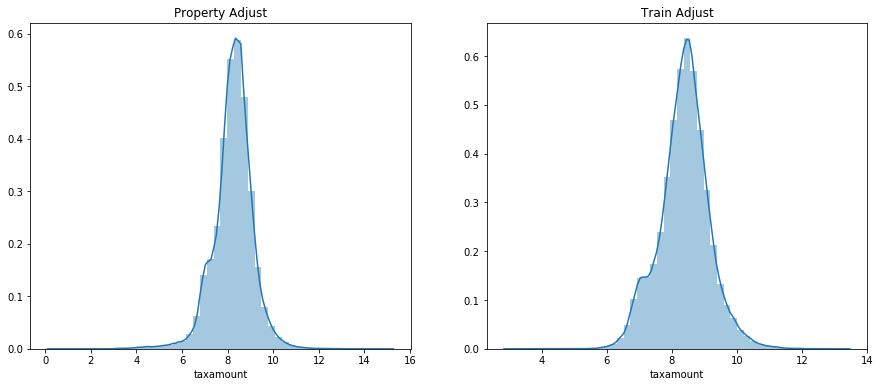

In [30]:
for f in numerical_features:
    num_process(imputefullsets,f,log=True)

9. Segment Data
-------------------------------------

Time Out
Values Which In Range Has A Ratio : 80.23%
Values large than 5.07855399998 and less than 7.24398266904 will be map to RL RG
Values Which In Range Has A Ratio : 94.99%
Values large than 6.25922805578 and less than 8.01994749735 will be map to RL RG
Time Out
Values Which In Range Has A Ratio : 88.30%
Values large than 6.45247930955 and less than 7.57070621849 will be map to RL RG
Values Which In Range Has A Ratio : 94.99%
Values large than 6.91102549768 and less than 8.57619144796 will be map to RL RG
Values Which In Range Has A Ratio : 95.00%
Values large than 6.25005899247 and less than 8.03714162354 will be map to RL RG
Time Out
Values Which In Range Has A Ratio : 99.20%
Values large than 5.9209115197 and less than 9.16483425097 will be map to RL RG
Time Out
Values Which In Range Has A Ratio : 86.29%
Values large than 0.467167716875 and less than 1.04750920412 will be map to RL RG
Time Out
Values Which In Range Has A Ratio : 74.84%
Values large than 0.817619775827 and less th

C:\Users\aeloyq\Anaconda2\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Time Out
Values Which In Range Has A Ratio : 76.29%
Values large than 4.01123649498 and less than 6.29194948825 will be map to RL RG


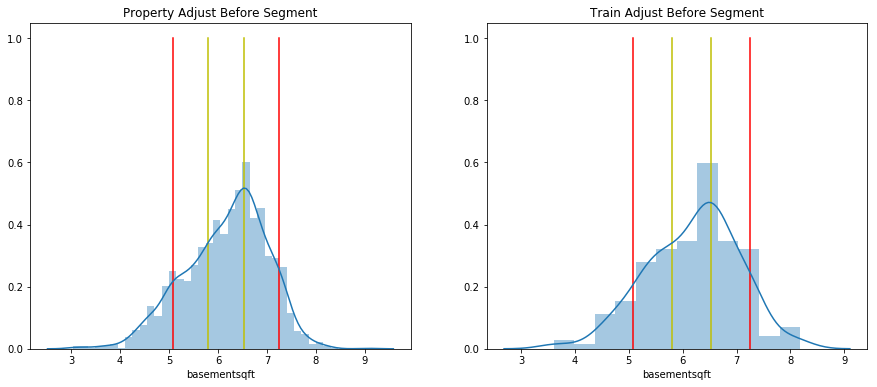

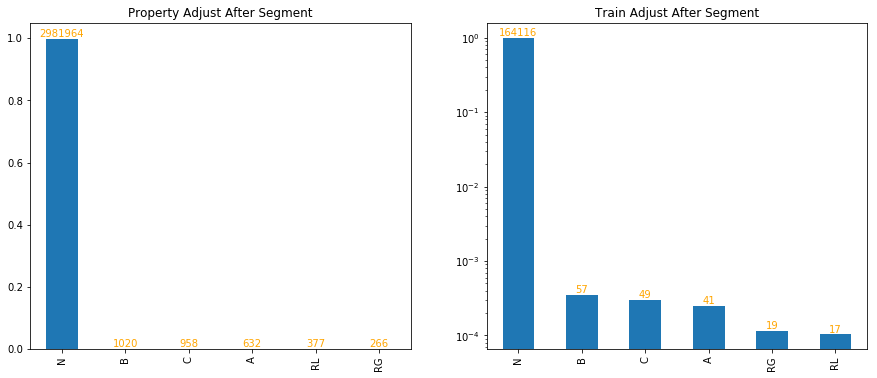

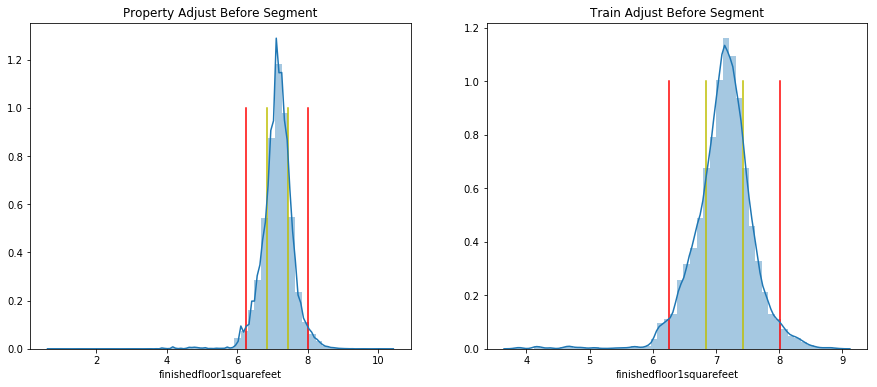

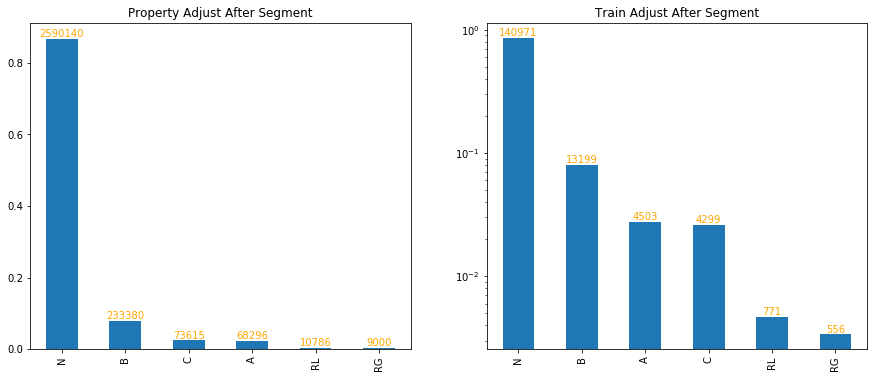

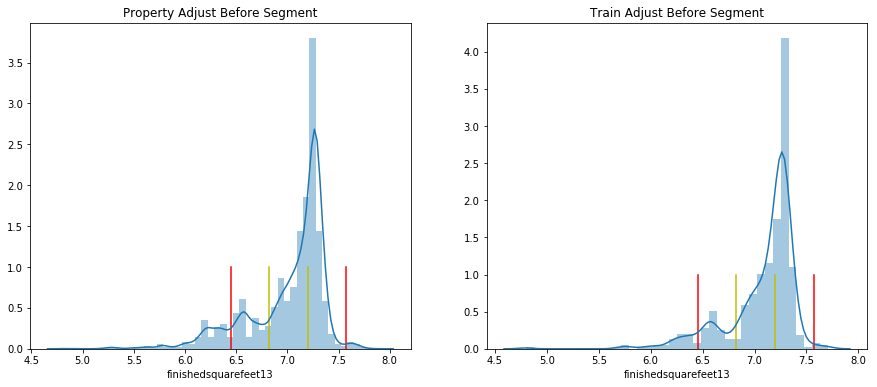

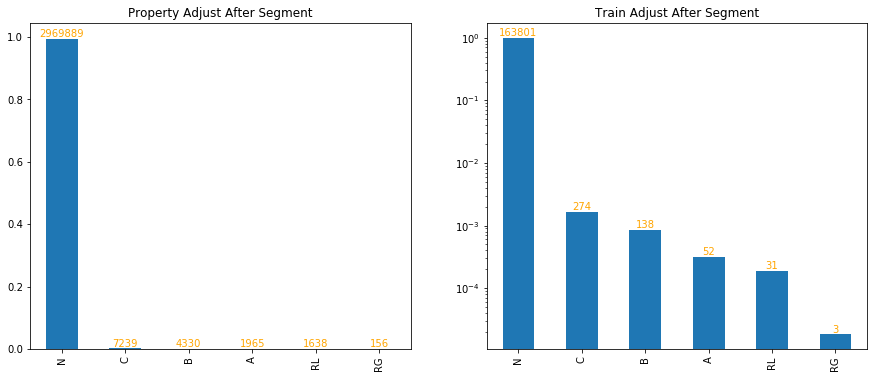

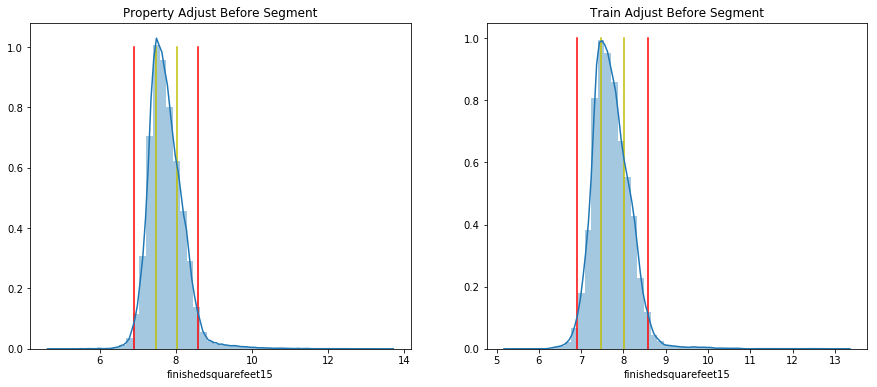

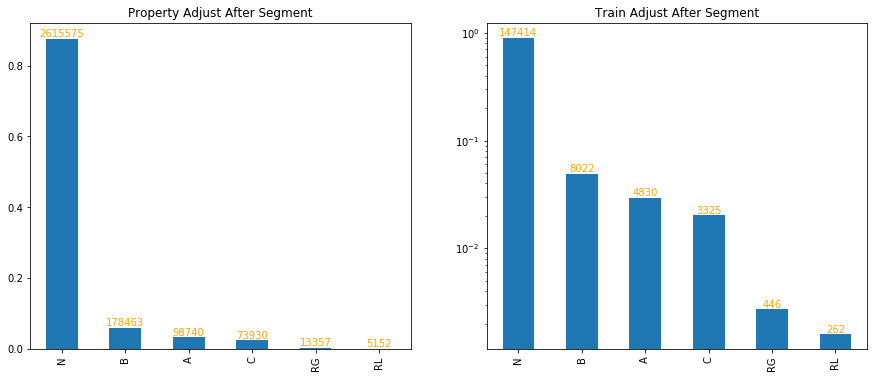

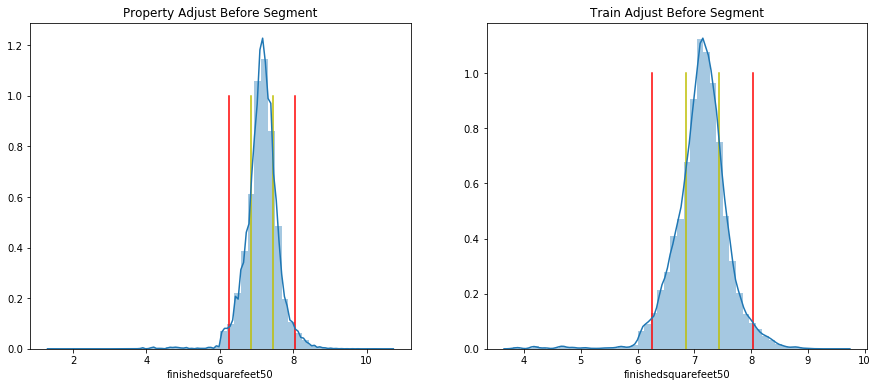

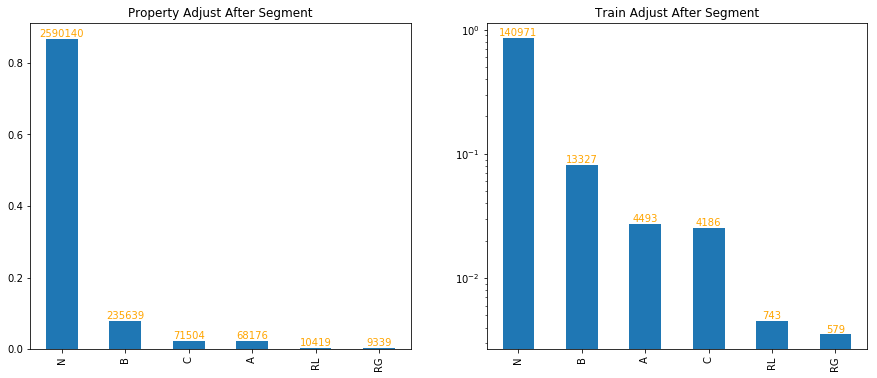

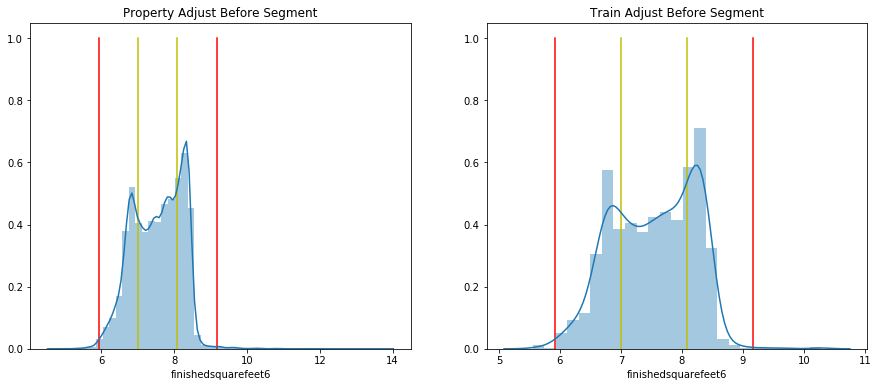

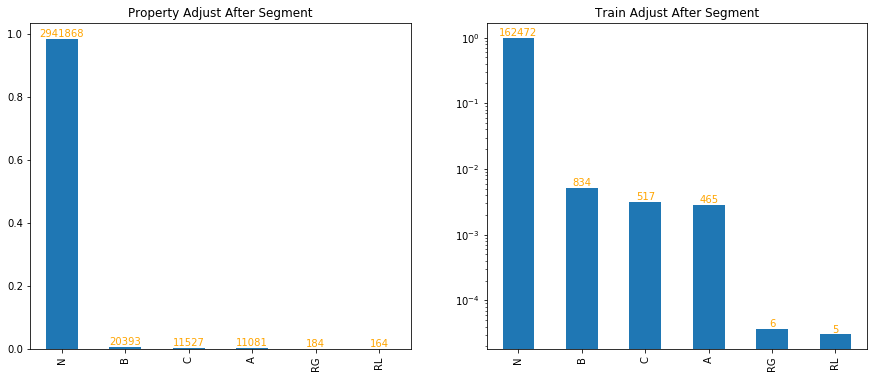

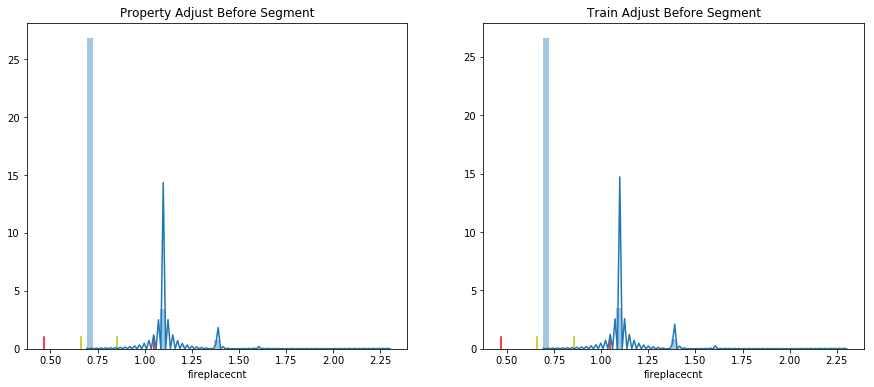

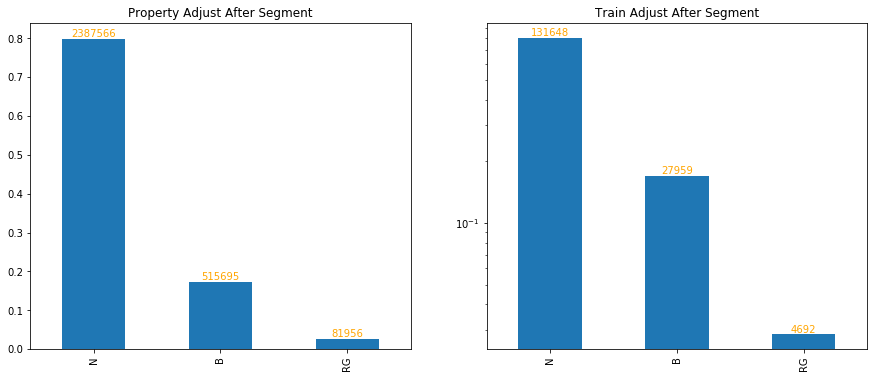

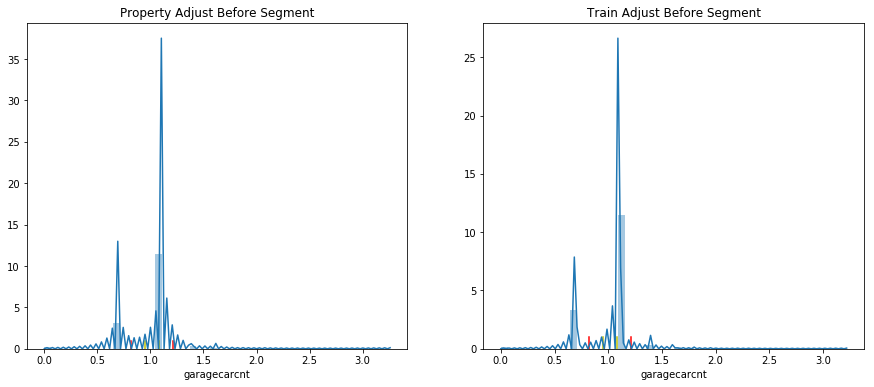

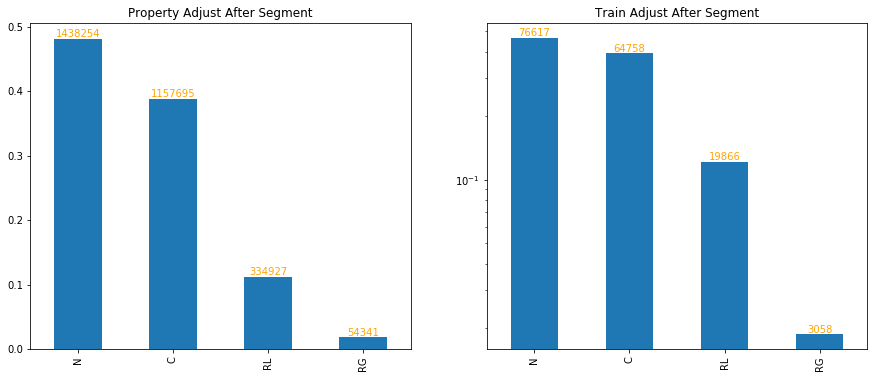

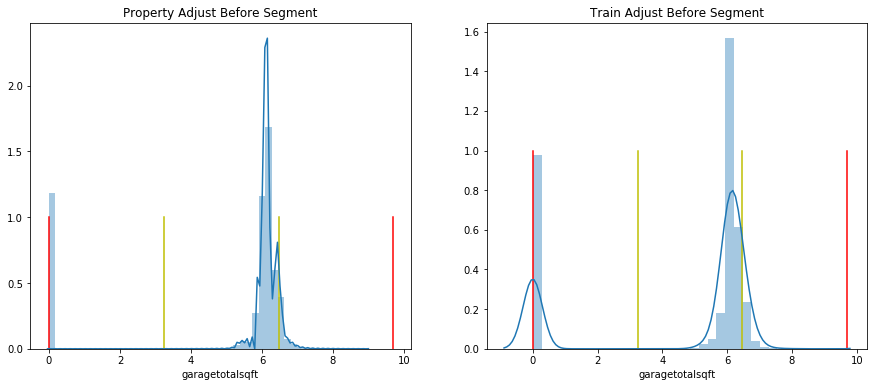

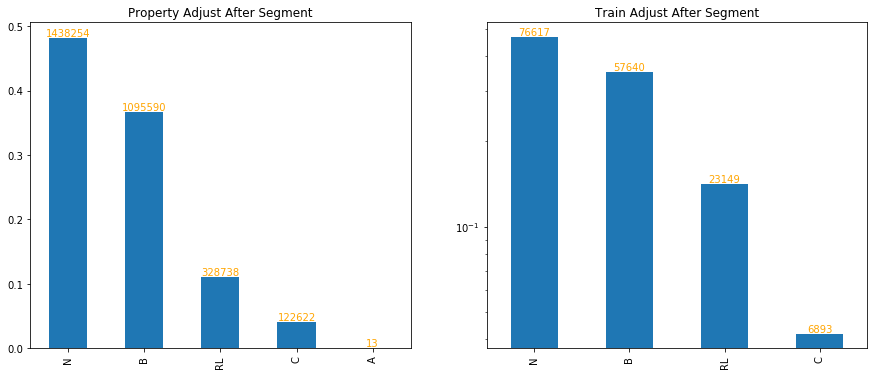

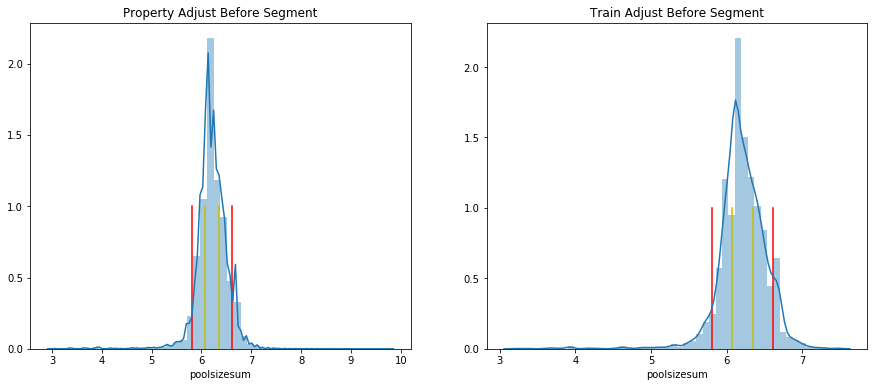

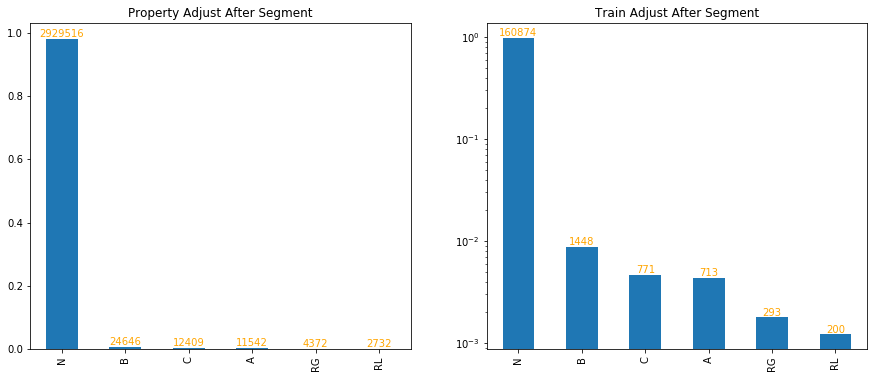

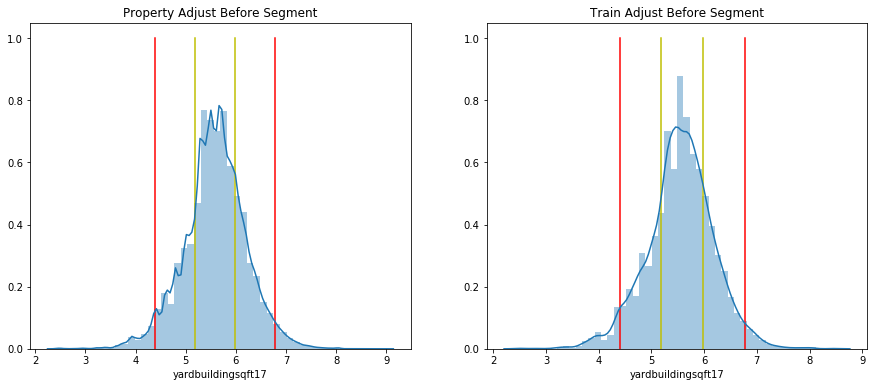

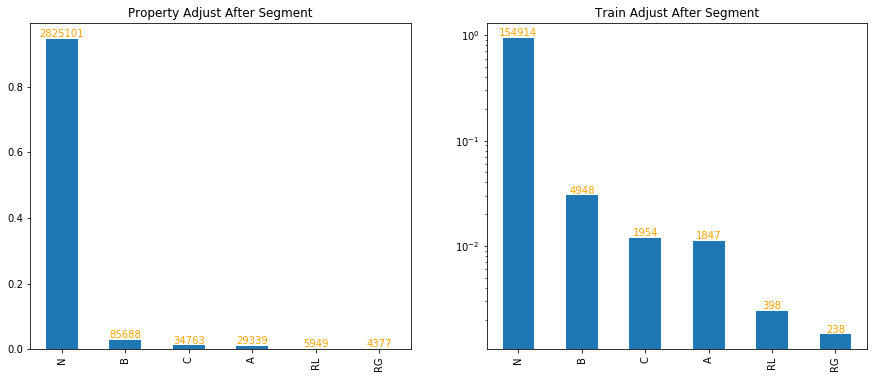

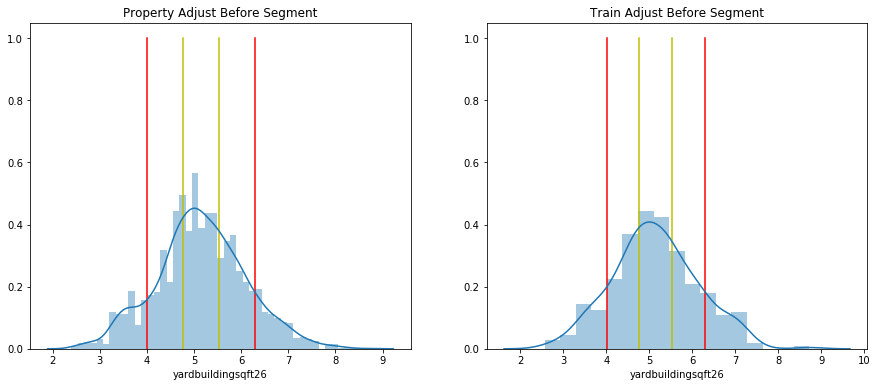

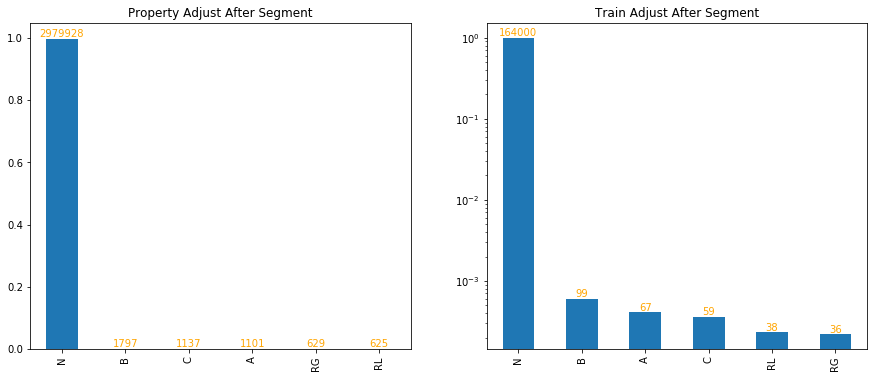

In [31]:
for f in segment_features:
    seg_process(imputefullsets,f,log=True)

10. Final Process
-------------------------------------

In [32]:
imputefullsets.to_csv('./Data/imputedproperties.csv')

In [33]:
#imputefullsets=pd.read_csv('./Data/imputedproperties.csv',low_memory=False)

In [34]:
print special

['latitude', 'longitude', 'propertycountylandusecode', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidneighborhood', 'regionidzip', 'yearbuilt', 'assessmentyear', 'taxdelinquencyyear', 'censustractandblock']


{'0400': 'M', '1': 'H', '070P': 'P', '1129': 'O', '0101': 'C', '0100': 'A', 'N': 'N', '1111': 'E', '1110': 'K', '122': 'B', '0200': 'G', '010E': 'J', '010D': 'I', '34': 'F', '010C': 'D', '0300': 'L'}


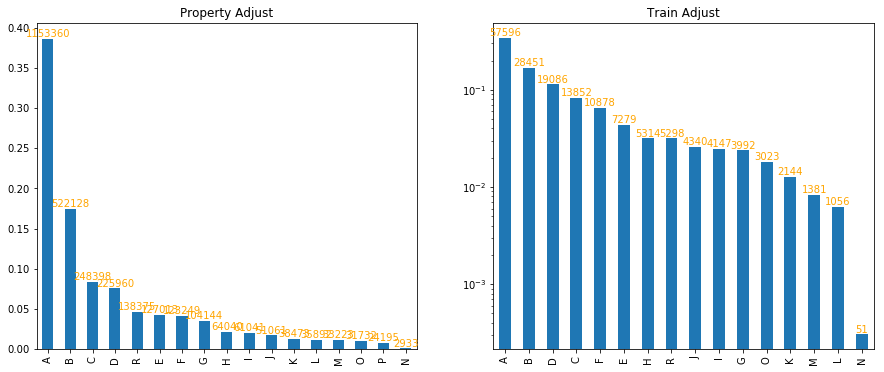

In [35]:
#'propertycountylandusecode'
ft='propertycountylandusecode'
imputefullsets[ft]=properties[ft]
def f(x):
    l=''
    for i in str(x):
        if i.isalpha():
            l=l+i
    if l=='':
        l='NAN1'
    return l
cat_process(imputefullsets,ft)
imputefullsets[ft]=imputefullsets[ft].apply(f)

In [36]:
from sklearn import mixture

In [45]:
#'rawcensustractandblock','censustractandblock', 'latitude', 'longitude'
clusterlocation=imputefullsets[['regionidcity', 'regionidzip','rawcensustractandblock','censustractandblock', 'latitude', 'longitude','fips']].copy()
clusterlocation=(clusterlocation-clusterlocation.mean())/clusterlocation.std()
model=mixture.GaussianMixture(n_components=8)
model.fit(clusterlocation)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=8, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [46]:
imputefullsets['clusterlocation']=model.predict(clusterlocation)

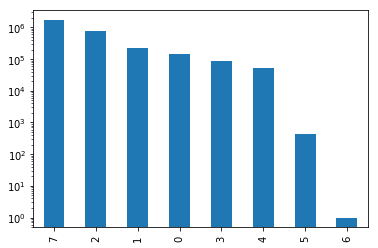

In [47]:
imputefullsets['clusterlocation'].value_counts().plot.bar(logy=True)

{10.0: 'F', 11.0: 'E', 12.0: 'D', 13.0: 'C', 14.0: 'B', 15.0: 'A', 'N': 'N'}


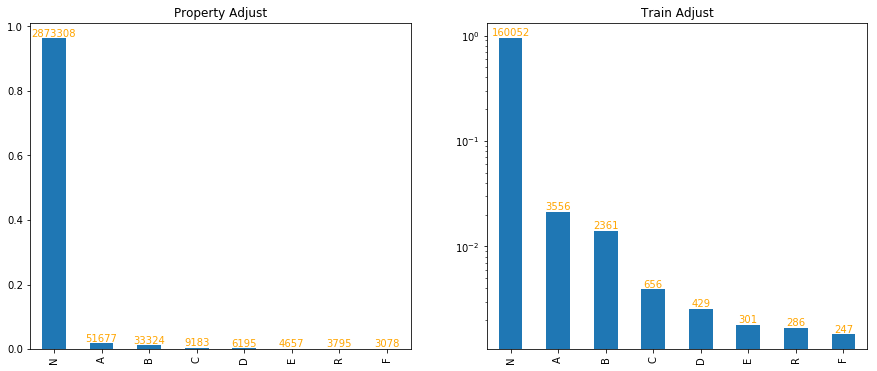

In [48]:
#'taxdelinquencyyear'
ft='taxdelinquencyyear'
cat_process(imputefullsets,'taxdelinquencyyear')
imputefullsets[ft]=preprocess_pipeline[ft](imputefullsets[ft])

In [49]:
#'yearbuilt', 'assessmentyear'
ft='yearbuilt'
imputefullsets[ft]=2017.-imputefullsets[ft]
ft='assessmentyear'
imputefullsets[ft]=2017.-imputefullsets[ft]

In [50]:
imputefullsets['propertycountylandusecode']=preprocess_pipeline['propertycountylandusecode'](properties['propertycountylandusecode'])

In [51]:
imputefullsets.to_csv('./Data/specialajustedproperties.csv')

In [52]:
# imputefullsets=pd.read_csv('./Data/specialajustedproperties.csv',low_memory=False)

In [53]:
for f in category_features:
    imputefullsets[f]=preprocess_pipeline[f](imputefullsets[f])

In [54]:
imputefullsets.to_csv('./Data/catajustedproperties.csv')

In [55]:
for f in numerical_features:
    imputefullsets[f]=preprocess_pipeline[f](imputefullsets[f])

In [56]:
imputefullsets.to_csv('./Data/numajustedproperties.csv')

In [57]:
for f in segment_features:
    imputefullsets[f]=preprocess_pipeline[f](imputefullsets[f])

In [58]:
imputefullsets.to_csv('./Data/segajustedproperties.csv')

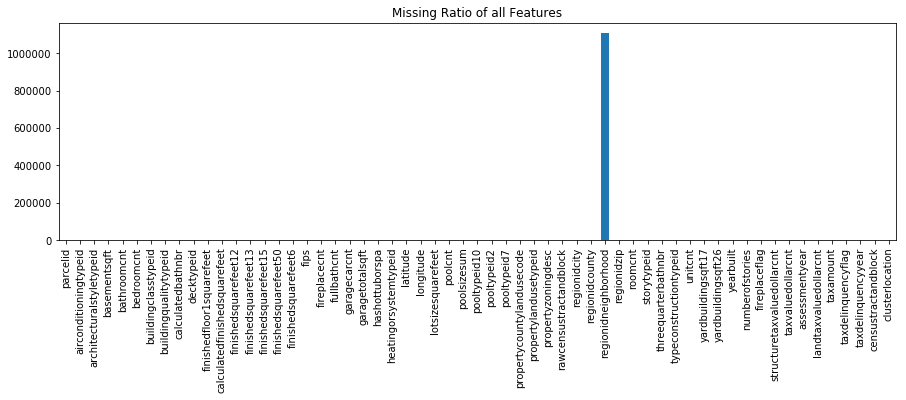

In [59]:
plt.figure(figsize=(15,4))
imputefullsets.isnull().sum().plot.bar()
plt.title('Missing Ratio of all Features')

11. Encoding and Normalize
-------------------------------------

In [63]:
data=imputefullsets.drop(['regionidneighborhood','Unnamed: 0'],axis=1).copy()

In [65]:
data.to_csv('./Data/datasetsclean.csv')

In [66]:
catglorical=category_features+segment_features+['clusterlocation','propertycountylandusecode', 'propertyzoningdesc', 'taxdelinquencyyear']
numerical=numerical_features+[ 'yearbuilt', 'assessmentyear']+['latitude', 'longitude', 'rawcensustractandblock','regionidcity', 'regionidzip', 'censustractandblock']
len(catglorical)+len(numerical)

57

In [67]:
data_encoded=pd.get_dummies(data, columns=catglorical, drop_first=False)

In [68]:
data_encoded.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,propertyzoningdesc_G,propertyzoningdesc_R,taxdelinquencyyear_A,taxdelinquencyyear_B,taxdelinquencyyear_C,taxdelinquencyyear_D,taxdelinquencyyear_E,taxdelinquencyyear_F,taxdelinquencyyear_N,taxdelinquencyyear_R
0,10754147,0.0,0.0,1.098612,7.513338,7.475117,1.098612,34144442.0,-118654084.0,11.359413,...,0,1,0,0,0,0,0,0,1,0
1,10759547,0.0,0.0,1.098612,7.513338,7.475117,1.098612,34140430.0,-118625364.0,8.314832,...,0,1,0,0,0,0,0,0,1,0
2,10843547,0.0,0.0,1.098612,11.198585,7.475117,1.098612,33989359.0,-118394633.0,11.052254,...,0,1,0,0,0,0,0,0,1,0
3,10859147,0.0,0.0,1.098612,8.530899,7.475117,1.098612,34148863.0,-118437206.0,8.925587,...,0,1,0,0,0,0,0,0,1,0
4,10879947,0.0,0.0,1.098612,7.482682,7.475117,1.098612,34194168.0,-118385816.0,9.049350,...,0,1,0,0,0,0,0,0,1,0


In [69]:
data_mean=data_encoded[catglorical+numerical].mean()

In [70]:
data_std=data_encoded[catglorical+numerical].std()

In [71]:
data_norm=(data_encoded[catglorical+numerical]-data_mean)/data_std

In [74]:
data_norm['parcelid']=data_encoded['parcelid']

12. Save File
----------------------------

In [72]:
data_encoded.to_csv('./Data/dataencode.csv')

In [76]:
data_norm.to_csv('./Data/datanorm.csv')